In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.nn import batch_normalization as BatchNormalization

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 8
epochs = 15
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [3]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [4]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory='live_data/train',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 267 images belonging to 2 classes.


In [5]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory='live_data/test',
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 60 images belonging to 2 classes.


In [6]:
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    for l in labels:
        if l == 0:
            print("FAKE", end=" ")
        else:
            print("REAL", end=" ")
    print(labels)

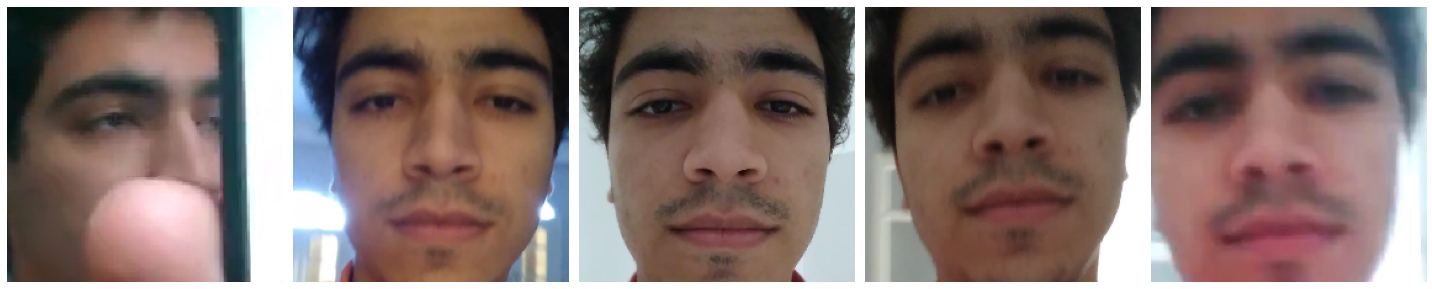

FAKE REAL REAL REAL FAKE [0. 1. 1. 1. 0.]


In [7]:
sample_images, sample_labels = next(train_data_gen)

plotImages(sample_images[:5], sample_labels[:5])

In [8]:
from tensorflow.keras.layers import Activation
input_shape =  (IMG_HEIGHT, IMG_WIDTH ,3)

In [9]:
def get_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])
    return model

In [10]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       7

In [14]:
total_train = 267
total_val = 60
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

NameError: name 'model' is not defined

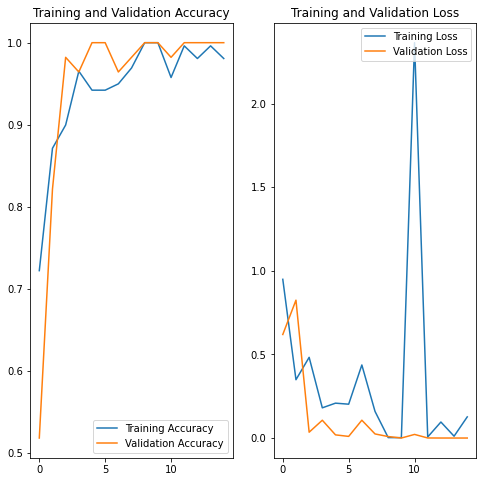

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
model.save_weights("second")

In [11]:
model.load_weights('second')

In [12]:
import cv2
#img = cv2.imread('faces/moaz/0.png')
img = cv2.imread('live_data/test/fake/103.png')
#img = cv2.imread('live_data/train/fake/0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape

(235, 236, 3)

In [13]:
s = np.resize(img, (224,224,3))

In [14]:
s.shape

(224, 224, 3)

In [15]:
s = np.resize(img, (224,224,3))
s = s[None, ...]

In [16]:
s.shape

(1, 224, 224, 3)

In [17]:
p = model.predict(s)

In [18]:
p

array([[0.]], dtype=float32)

# ----------------------------------------------- 

In [19]:
import face_recognition
from sklearn import svm
import os

In [20]:
encodings = []
names = []

train_dir = os.listdir('faces/')

# loop through each person in the directory
i=1
for person in train_dir:
    pix  = os.listdir('faces/' + person)
    
    # loop through each training image for the current person
    for person_img in pix:
        # get the face encodings for the face in each image file
        face = face_recognition.load_image_file('faces/'+person+'/'+person_img)
        face_bounding_boxes = face_recognition.face_locations(face, number_of_times_to_upsample=0, model='cnn')

        #If training image contains exactly one face
        if len(face_bounding_boxes) == 1:
            face_encodings = face_recognition.face_encodings(face)
            if len(face_encodings) > 0:
                face_enc = face_encodings[0]
            else:
                print(str(i)+"."+person + "/" + person_img + " was skipped and can't be used for training")
                i+=1
                continue
            # Add face encoding for current image with corresponding label (name) to the training data
            encodings.append(face_enc)
            names.append(person)
        else:
            print(str(i)+"."+person + "/" + person_img + " was skipped and can't be used for training")
            i+=1

1.moaz/3.png was skipped and can't be used for training
2.moaz/4.png was skipped and can't be used for training
3.ziad/2.png was skipped and can't be used for training
4.ziad/5.png was skipped and can't be used for training
5.ziad/6.png was skipped and can't be used for training
6.ziad/7.png was skipped and can't be used for training


In [21]:
# create and train the svc classifier
clf = svm.SVC(gamma='scale')
clf.fit(encodings, names)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
import cv2
import PIL.Image as Image


process_this_frame = True
# Get a reference to webcam #0 (the default one)
video_capture = cv2.VideoCapture(0)


while True:
    ret, frame = video_capture.read()
    
    # Resize frame of video to 1/4 size for faster face recognition processing
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
    
    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    rgb_small_frame = small_frame[:, :, ::-1]
    
    if process_this_frame:
        # Find all the faces and face encodings in the current frame of video
        face_locations = face_recognition.face_locations(rgb_small_frame)
        face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)
        
        face_names = []
        for face_encoding in face_encodings:
            name = clf.predict([face_encoding])
            face_names.append(name[0])
            
    process_this_frame = not process_this_frame
    
    # Display the results
    for (top, right, bottom, left), name in zip(face_locations, face_names):
        # re-build the image to send to model
        face_image = frame[top:bottom, left:right]
        pil_image = Image.fromarray(face_image)
        
        # prepare image for inference
        s = np.resize(pil_image, (224,224,3))
        s = s[None, ...]
        
        # make prediction
        p = model.predict(s)
        if p < 0.5:
            name += ' REAL'
        else:
            name += 'FAKE'
        
        # Scale back up face locations since the frame we detected in was scaled to 1/4 size
        top *= 4
        right *= 4
        bottom *= 4
        left *= 4

        # Draw a box around the face
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

        # Draw a label with a name below the face
        cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

    # Display the resulting image
    cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release handle to the webcam
video_capture.release()
cv2.destroyAllWindows()